In [12]:
pip install opencv-python scikit-learn matplotlib tqdm

In [13]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [14]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
import numpy as np

def load_cifar100_torch(n_samples=10000):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)

    X, y = [], []
    for i in range(n_samples):
        img, label = dataset[i]
        img = img.numpy().transpose(1, 2, 0) * 255
        X.append(img.astype(np.uint8))
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [15]:
# Resize image and convert to grayscale
def preprocess_image(img, size=(128, 128)):
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

In [16]:
# Extract ORB and HOG features
def extract_features(img):
    # ORB descriptors
    orb = cv2.ORB_create(nfeatures=200)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    if descriptors is None:
        descriptors = np.zeros((1, 32))  # fallback
    return descriptors

In [17]:
# Extract HOG descriptors
def extract_hog(img):
    hog = cv2.HOGDescriptor()
    h = hog.compute(img)
    return h.flatten()

In [18]:
# Create BoVW feature vector
def compute_bovw(descriptor_list, k=100):
    all_descriptors = np.vstack(descriptor_list)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=k*3)
    kmeans.fit(all_descriptors)
    bovw_features = []
    for desc in descriptor_list:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(k+1))
        bovw_features.append(hist)
    return np.array(bovw_features), kmeans

In [21]:
def run_pipeline():
    X, y = load_cifar100_torch(n_samples=2000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    orb_descriptors_train = []
    hog_features_train = []

    print("Extracting features from training images...")
    for img in tqdm(X_train):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_train.append(orb_desc)
        hog_features_train.append(hog_feat)

    print("Building Bag of Visual Words...")
    bovw_train, kmeans = compute_bovw(orb_descriptors_train, k=100)

    # Combine BoVW and HOG features
    hog_features_train = np.array(hog_features_train)
    combined_train = np.hstack((bovw_train, hog_features_train))

    # Scale features
    scaler = StandardScaler()
    combined_train = scaler.fit_transform(combined_train)

    # print("Training SVM...")
    # clf = SVC(kernel='linear', C=1.0)
    # clf.fit(combined_train, y_train)

    print("Hyperparameter tuning using RandomizedSearchCV...")

    param_dist = {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'rbf']
    }

    svc = SVC(probability=False)  # save RAM

    random_search = RandomizedSearchCV(
        estimator=svc,
        param_distributions=param_dist,
        n_iter=3,            # keep it small
        cv=2,                # fewer folds
        scoring='accuracy',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(combined_train, y_train)
    clf = random_search.best_estimator_

    print("Best Parameters:", random_search.best_params_)
    print("Best CV Score:", random_search.best_score_)


    # ---- TESTING ----
    print("Extracting features from test images...")
    orb_descriptors_test = []
    hog_features_test = []
    for img in tqdm(X_test):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_test.append(orb_desc)
        hog_features_test.append(hog_feat)

    bovw_test = []
    for desc in orb_descriptors_test:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1))
        bovw_test.append(hist)
    bovw_test = np.array(bovw_test)

    hog_features_test = np.array(hog_features_test)
    combined_test = np.hstack((bovw_test, hog_features_test))
    combined_test = scaler.transform(combined_test)

    print("Evaluating...")
    y_pred = clf.predict(combined_test)
    print(classification_report(y_test, y_pred))

    return y_train, y_test, y_pred, clf, combined_test, random_search # for further plotting


In [22]:
y_train, y_test, y_pred, clf, combined_test, random_search = run_pipeline()

Extracting features from training images...


100%|██████████| 1600/1600 [00:01<00:00, 884.42it/s]


Building Bag of Visual Words...
Hyperparameter tuning using RandomizedSearchCV...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best Parameters: {'C': np.float64(3.845401188473625), 'kernel': 'linear'}
Best CV Score: 0.09625
Extracting features from test images...


100%|██████████| 400/400 [00:00<00:00, 870.74it/s]


Evaluating...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         5
           5       0.14      0.25      0.18         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.25      0.17      0.20         6
           9       1.00      0.20      0.33         5
          10       0.00      0.00      0.00         4
          11       0.11      0.12      0.12         8
          12       0.29      0.40      0.33         5
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [23]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_model_evaluation(y_test, y_pred, clf, combined_test):
    classes_to_plot = list(range(10))  # Limit to first 10 classes
    num_classes = len(np.unique(y_test))

    # --- Confusion Matrix ---
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classes_to_plot)
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes_to_plot).plot(ax=ax1)
    plt.title("Confusion Matrix (Top 10 Classes)")
    plt.tight_layout()

    # --- Accuracy Heatmap ---
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=classes_to_plot, yticklabels=classes_to_plot)
    ax2.set_title("Accuracy Heatmap (Top 10 Classes)")
    ax2.set_xlabel("Predicted Label")
    ax2.set_ylabel("True Label")
    plt.tight_layout()

    # --- Precision-Recall Curve ---
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(combined_test)
        y_test_bin = label_binarize(y_test, classes=range(num_classes))

        fig3, ax3 = plt.subplots(figsize=(10, 8))
        for i in classes_to_plot:
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ax3.plot(recall, precision, label=f"Class {i}")
        ax3.set_title("Precision-Recall Curves (Top 10 Classes)")
        ax3.set_xlabel("Recall")
        ax3.set_ylabel("Precision")
        ax3.legend(loc="best")
        plt.tight_layout()

    # --- Precision, Recall, F1 Score Matrix ---
    print("\nGenerating Precision-Recall-F1 Matrix (Top 10 Classes)...")
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

    # Filter only the top 10 classes (0–9 as strings)
    report_df = report_df.loc[[str(i) for i in classes_to_plot]]

    fig4, ax4 = plt.subplots(figsize=(12, 4))
    sns.heatmap(report_df[["precision", "recall", "f1-score"]].astype(float),
                annot=True, fmt=".2f", cmap="Blues", ax=ax4)
    ax4.set_title("Precision, Recall, F1-score (Top 10 Classes)")
    ax4.set_xlabel("Metric")
    ax4.set_ylabel("Class")
    plt.tight_layout()

    plt.show()



Generating Precision-Recall-F1 Matrix (Top 10 Classes)...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

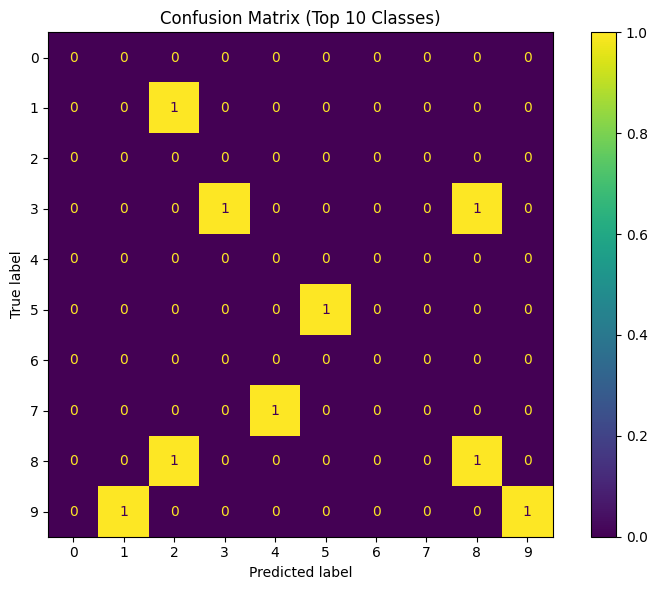

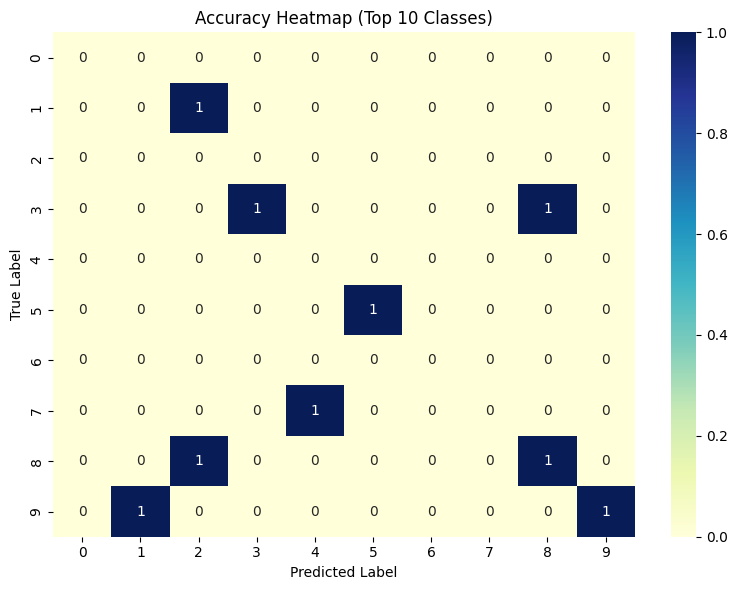

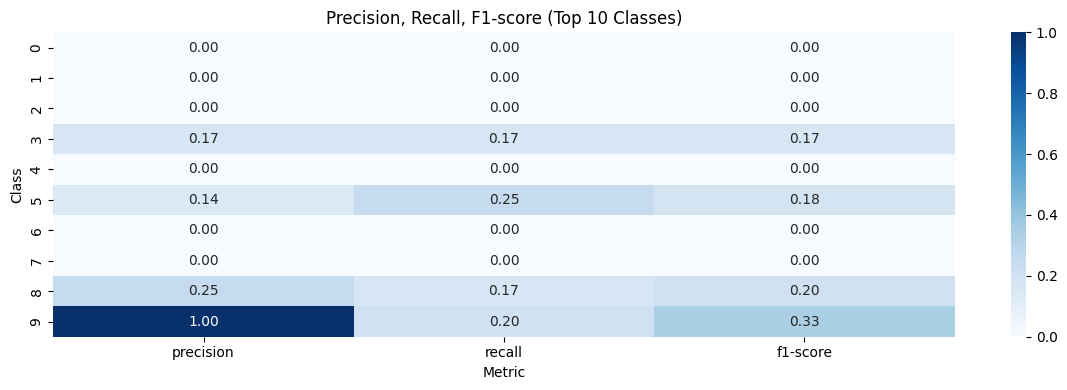

In [24]:
plot_model_evaluation(y_test, y_pred, clf, combined_test)

In [ ]:
# def plot_hyperparameter_results(grid_search):
#     print("\nBest Parameters:", grid_search.best_params_)
#     print("Best Cross-Validation Score:", grid_search.best_score_)

#     results = pd.DataFrame(grid_search.cv_results_)

#     if 'param_C' in results.columns and 'param_kernel' in results.columns:
#         pivot = results.pivot(index="param_C", columns="param_kernel", values="mean_test_score")

#         plt.figure(figsize=(8, 6))
#         sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
#         plt.title("GridSearchCV Mean Test Score")
#         plt.xlabel("Kernel")
#         plt.ylabel("C")
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("Unable to plot hyperparameter grid. Only 1D search space or missing parameters.")


In [ ]:
# plot_hyperparameter_results(grid_search)

In [27]:
def run_pipeline():
    X, y = load_cifar100_torch(n_samples=2000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    orb_descriptors_train = []
    hog_features_train = []

    print("Extracting features from training images...")
    for img in tqdm(X_train):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_train.append(orb_desc)
        hog_features_train.append(hog_feat)

    print("Building Bag of Visual Words...")
    bovw_train, kmeans = compute_bovw(orb_descriptors_train, k=100)

    # Combine BoVW and HOG features
    hog_features_train = np.array(hog_features_train)
    combined_train = np.hstack((bovw_train, hog_features_train))

    # Scale features
    scaler = StandardScaler()
    combined_train = scaler.fit_transform(combined_train)

    # print("Training SVM...")
    # clf = SVC(kernel='linear', C=1.0)
    # clf.fit(combined_train, y_train)

    print("Hyperparameter tuning using RandomizedSearchCV...")

    param_dist = {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'rbf']
    }

    svc = SVC(probability=False)  # save RAM

    random_search = RandomizedSearchCV(
        estimator=svc,
        param_distributions=param_dist,
        n_iter=3,            # keep it small
        cv=2,                # fewer folds
        scoring='accuracy',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(combined_train, y_train)

    # Print best parameters
    print("Best Parameters:", random_search.best_params_)
    print("Best CV Score:", random_search.best_score_)

    # Retrain final model with probability=True
    best_params = random_search.best_params_
    print("Retraining final model with probability=True for evaluation...")
    clf = SVC(**best_params, probability=True)
    clf.fit(combined_train, y_train)


    # ---- TESTING ----
    print("Extracting features from test images...")
    orb_descriptors_test = []
    hog_features_test = []
    for img in tqdm(X_test):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_test.append(orb_desc)
        hog_features_test.append(hog_feat)

    bovw_test = []
    for desc in orb_descriptors_test:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1))
        bovw_test.append(hist)
    bovw_test = np.array(bovw_test)

    hog_features_test = np.array(hog_features_test)
    combined_test = np.hstack((bovw_test, hog_features_test))
    combined_test = scaler.transform(combined_test)

    print("Evaluating...")
    y_pred = clf.predict(combined_test)
    print(classification_report(y_test, y_pred))

    return y_train, y_test, y_pred, clf, combined_test, random_search # for further plotting


In [28]:
y_train, y_test, y_pred, clf, combined_test, random_search = run_pipeline()

Extracting features from training images...


100%|██████████| 1600/1600 [00:03<00:00, 455.53it/s]


Building Bag of Visual Words...
Hyperparameter tuning using RandomizedSearchCV...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best Parameters: {'C': np.float64(3.845401188473625), 'kernel': 'linear'}
Best CV Score: 0.095625
Retraining final model with probability=True for evaluation...
Extracting features from test images...


100%|██████████| 400/400 [00:00<00:00, 901.81it/s]


Evaluating...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         5
           5       0.14      0.25      0.18         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.25      0.17      0.20         6
           9       1.00      0.20      0.33         5
          10       0.00      0.00      0.00         4
          11       0.11      0.12      0.12         8
          12       0.29      0.40      0.33         5
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Generating Precision-Recall-F1 Matrix (Top 10 Classes)...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

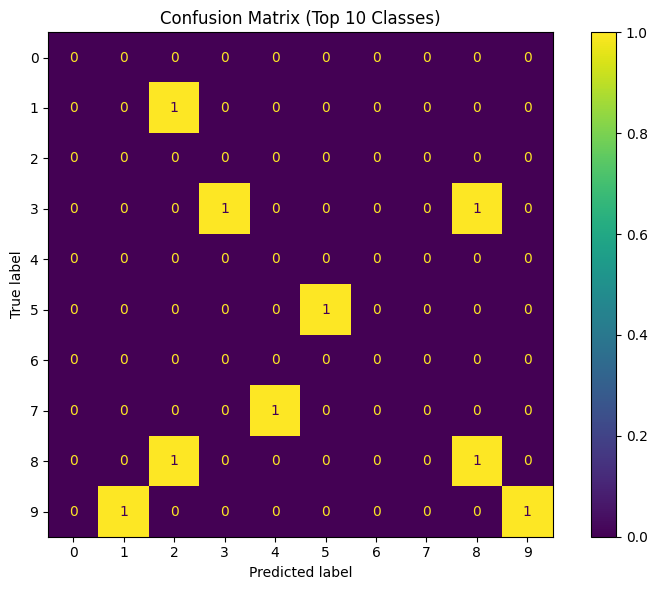

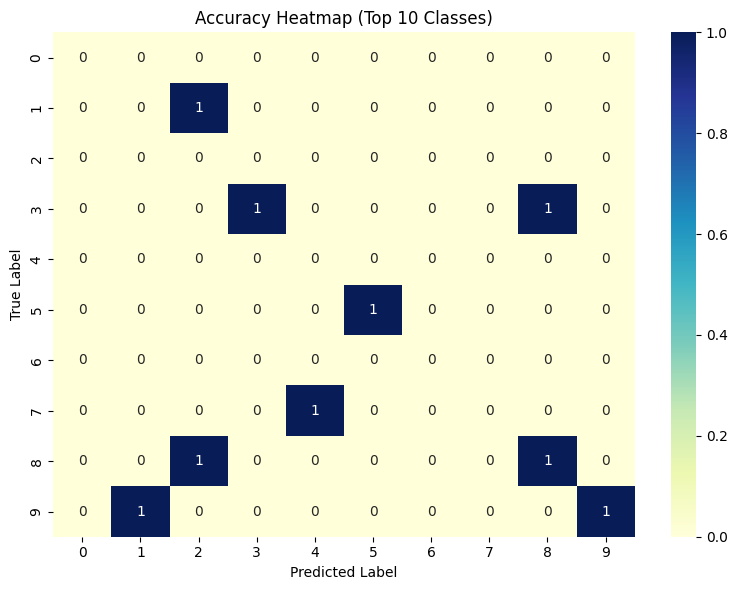

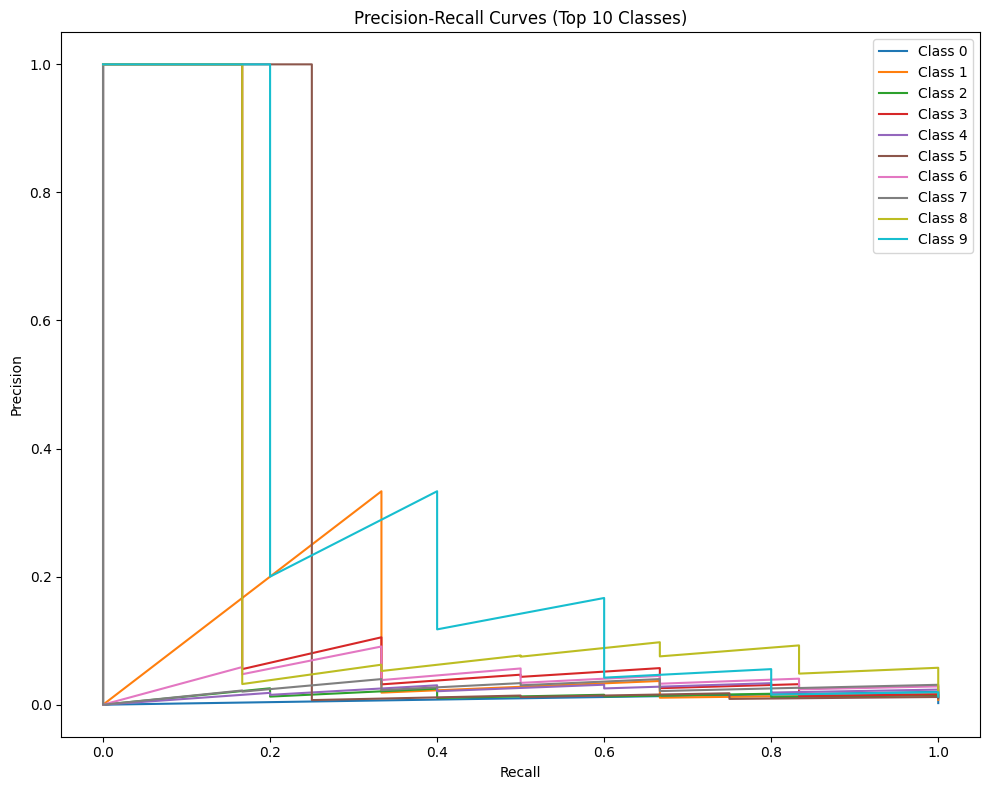

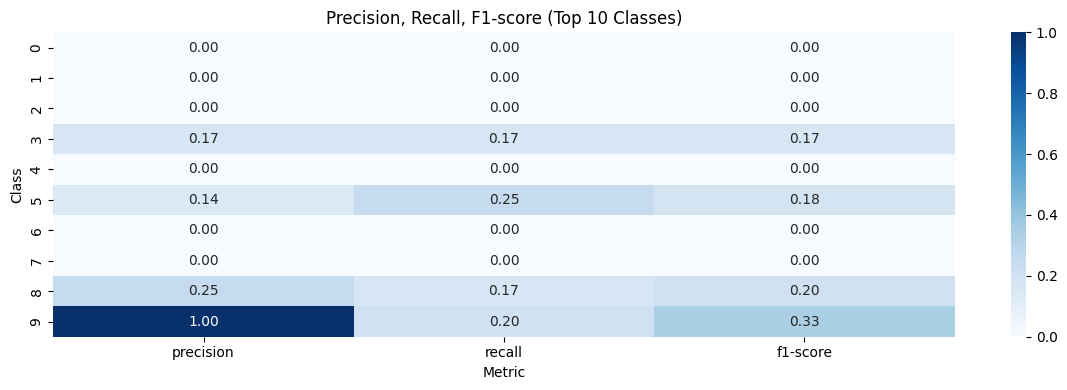

In [29]:
plot_model_evaluation(y_test, y_pred, clf, combined_test)